In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random

# load data

In [2]:
d = pd.read_csv('train.csv')
print('done')

done


In [3]:
print(d.shape)
d.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


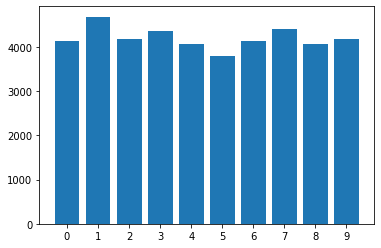

In [4]:
# view class distribution
x = [i for i in range(0,10)]
plt.bar(x, d['label'].value_counts().sort_index())
plt.xticks(x)
plt.show()

# preprocessing

In [5]:
# convert to matrix
d = d.values
print('done')

done


In [6]:
# separate features (X) from labels (y)
d_X = d[:,1:] # (42000, 784)
d_y = d[:,0]  # (42000,)
d_y = d_y[:, None]

# normalise features
print(f'range before normalisation: {[d_X.min(),d_X.max()]}')
d_X = d_X / 255
print(f'range after normalisation: {[d_X.min(),d_X.max()]}')

range before normalisation: [0, 255]
range after normalisation: [0.0, 1.0]


## split data into training and validation sets

In [7]:
def train_val_split(X, y, val_size=0.25):
    """splits dataset into training and validation set"""
    
    d_size = X.shape[0]
    sep = int(val_size * d_size)
    inds = list(range(d_size))
    random.shuffle(inds)
    train_inds, val_inds = inds[sep:], inds[:sep]

    X_t, X_v = d_X[train_inds, :], d_X[val_inds, :]
    y_t, y_v = d_y[train_inds], d_y[val_inds]
    
    return X_t, X_v, y_t, y_v


In [354]:
# split into training and validation set
X_trn, X_val, y_trn, y_val = train_val_split(d_X, d_y, val_size=0.20)
print('done')

print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

done
(33600, 784) (8400, 784) (33600, 1) (8400, 1)


# class definition

In [356]:

class MLP:
    def __init__(self, architecture, batch_size):
        
        # can only accept a 3 layer architecture for now
        self.n = architecture[0]
        self.h = architecture[1]
        self.out = architecture[2]
        self.batch_size = batch_size
        
        # randomly initialise parameters close to 0 between [-ε_init,ε_init] 
        limit_h = 1/np.sqrt(self.h)
        limit_out = 1/np.sqrt(self.out)
        
        self.w1 = np.random.uniform(-limit_h, limit_h, (self.n, self.h))
        self.w2 = np.random.uniform(-limit_out, limit_out, (self.h, self.out))
        self.b1 = np.zeros((self.h, 1))
        self.b2 = np.zeros((self.out, 1))

    def forward(self, x):
        
        self.z1 = np.dot(x, self.w1) + self.b1.T
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2.T
        self.a2 = self.softmax(self.z2)
        
        return self.a2
    
    def cel(self, y, yhat):
        # y -> batch_size x 1 matrix (ground truth)
        # yhat -> batch_size x 10 matrix (predictions)
    
        # one-hot encode y
        targets = y.reshape(-1)
        y_onehot = np.eye(yhat.shape[1])[targets]
        
        self.loss = -np.sum( y_onehot * np.log(yhat + 1e-8))
        # incl. +1e-8 to make the calculation stable
        return self.loss
    
    def backprop(self, y, x):
        
        # one-hot encode y
        targets = y.reshape(-1)
        y_onehot = np.eye(self.out)[targets]
        
        delta_a2 = self.a2 - y_onehot
        delta_a1 = np.dot(delta_a2, self.w2.T) * self.relu(self.z1, derivative=True)
        
        self.dJ_dw2 = np.dot(self.a1.T, delta_a2) / self.batch_size
        self.dJ_dw1 = np.dot(x.T, delta_a1) / self.batch_size
        self.dJ_db2 = np.sum(delta_a2.T, axis=1, keepdims=True) / self.batch_size
        self.dJ_db1 = np.sum(delta_a1.T, axis=1, keepdims=True) / self.batch_size
    
    def grad_descent(self, lr):

        self.w1 -= lr * self.dJ_dw1
        self.b1 -= lr * self.dJ_db1 
        self.w2 -= lr * self.dJ_dw2
        self.b2 -= lr * self.dJ_db2
        
    def train(self, X, Y, epochs, lr=0.01, timer=True, return_params=False):
        # X -> m x self.n matrix
        # y -> m x 1 matrix
        
        loss_hx = []
        m = X.shape[0]
        self.lr = lr
        t0 = time.time()
        
        for epoch in range(epochs):
            
            epoch_loss = 0
            
            # mini-batch grad descent
            for i in range(0, m, self.batch_size):
                
                # get batch fron training data
                x = X[i:i+self.batch_size, :] 
                y = Y[i:i+self.batch_size,:]
            
                preds = self.forward(x)
                loss = self.cel(y, preds)
                self.backprop(y, x)
                self.grad_descent(self.lr)
                
                epoch_loss += loss
                
            loss_hx.append(epoch_loss)
            if epoch%20==0: print(f'{epoch}', end="   ")
        
        t1 = time.time()
        print(f'training time: {t1-t0}')
        
        return loss_hx
        
    def predict(self, X_test):
        
        class_probabilities = self.forward(X_test)
        
        # index of max value for each example
        predictions = class_probabilities.argmax(axis=1)
        # return predictions as (m x 1) matrix
        return predictions[:, None]
    
    def relu(self, x, derivative=False):
        if derivative:
            return (x > 0)
        return np.maximum(x, 0)

    def softmax(self, x):
        exps = np.exp(x - np.max(x)) # subtracting max makes calculation stable
        exps_sums = exps.sum(axis=1)
        return exps / exps_sums[:,None]


In [357]:
# function for checking accuracy of predictions

from sklearn.metrics import precision_recall_fscore_support as score

def accuracy(yhat, y):
    # y and yhat are both m x 1 matrices
    
    #recall=(tp)/(tp+fn); precision=(tp)/(tp+fp); F=2(P.R/(P+R))
    precision, recall, fscore, support = score(y, yhat)
    assessment = pd.DataFrame({'precision': precision,
                               'recall': recall,
                               'fscore': fscore,
                               'support': support})
    
    return assessment


# training a model

0   20   40   60   80   100   120   140   160   180   200   220   240   260   280   300   320   340   360   380   400   420   440   460   480   training time: 116.76389288902283
loss of last epoch: 14.283472662375893


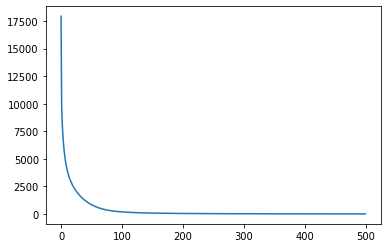

In [358]:
# define model
model = MLP(architecture=[784, 30, 10], 
            batch_size=64)

# train model - store loss in each epoch in losses
losses = model.train(X_trn, y_trn, epochs=500, lr=0.10)

print(f'loss of last epoch: {losses[-1]}')
plt.plot(losses)


## evaluate model

In [359]:
# make predictions
predictions = model.predict(X_val)
print(predictions.shape)

# assess accuracy
accuracy(predictions, y_val)

(8400, 1)


,precision,recall,fscore,support
0,0.970552,0.985056,0.977750,803
1,0.980932,0.983015,0.981972,942
2,0.962010,0.942377,0.952092,833
3,0.951276,0.950174,0.950725,863
4,0.964158,0.957295,0.960714,843
5,0.956975,0.944659,0.950777,777
6,0.972121,0.972121,0.972121,825
7,0.963415,0.964484,0.963949,901
8,0.928121,0.947233,0.937580,777
9,0.939213,0.942584,0.940896,836


# submission

In [350]:
# load testing data
test_data = pd.read_csv('./test.csv')

# mean normalisation and feature scaling
test_data = test_data/255

print('done')

done


In [351]:
# convert to np array
test_data_arr = test_data.values

# make predictions
test_preds = model.predict(test_data_arr)
print(test_preds.shape)
print(len(test_preds))

(28000, 1)
28000


In [352]:
# convert to df
solns = pd.DataFrame({'ImageId': list(range(1, len(test_preds)+1)),
                      'Label':test_preds[:,0]})
print(solns.head())

# save to file
solns.to_csv('submission.csv', index=False, header=True)


   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


## submission record

In [ ]:
# 25 hidden layers; batch size 100; epochs 300; lr 0.05; val_size 0.25 -> 0.95285 
# 25 hidden layers; batch size 100; epochs 380; lr 0.08; val_size 0.25-> 0.95342
# 30 hidden layers; batch size 100; epochs 500; lr 0.1; val_size 0.2 -> 0.95900
# 35 hidden layers; batch size 64; epochs 500; lr 0.16; val_size 0.2 -> 0.95914
# 60 hidden layers; batch size 64; epochs 500; lr 0.16; val_size 0.2 -> 0.96900
# 60 hidden layers; batch size 32; epochs 500; lr 0.16; val_size 0.2 -> 0.97028
# 70 hidden layers; batch size 24; epochs 500; lr 0.18; val_size 0.2 -> 0.97128
# 70 hidden layers; batch size 24; epochs 500; lr 0.18; val_size 0.01 -> 0.97242

In [ ]:
# initialising parameters based on square root of number of nodes in layer gives much lower loss
# compared to initialising from normal distribution

# this is better...
w1 = np.random.uniform(-1/np.sqrt(h), 1/np.sqrt(h), (n, h))
w2 = np.random.uniform(-1/np.sqrt(out), 1/np.sqrt(out), (h, out))

# compared to this
w1 = np.random.normal(0, 1, (n, h))
w2 = np.random.normal(0, 1, (h, out))